# Online Next Step Prediction

This notebook shows how to:


1.   Train a NextStep-RNN on multiple time steps
2.   Clone the model many times in order to use multiple model with differen states at a time
2.   And use this for sequential single step predictions ("random walk")



In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

TensorFlow 2.x selected.


In [2]:
import os
import random
import itertools

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime
from collections import defaultdict

# custom modules
import data
import model

print('Tensorflow version:', tf.__version__)

print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [20, 10]

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.0.0
GPU support: True


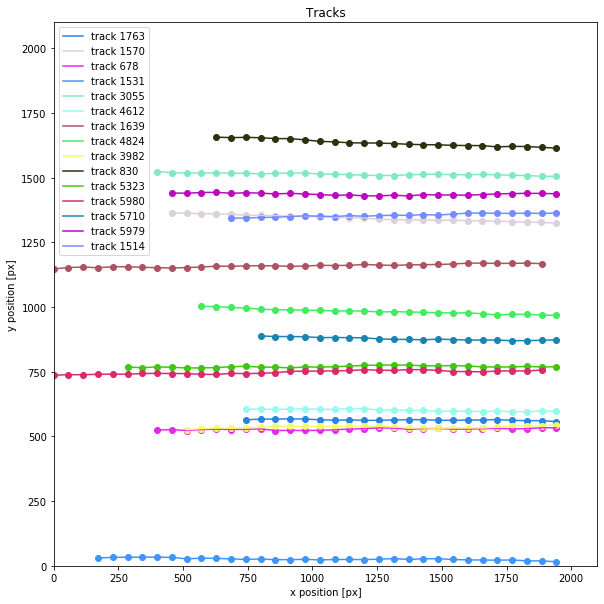

In [6]:
# Data loading
num_time_steps = 35
batch_size = 128
nan_value = 0
belt_width = 2000

fake_data_set = data.FakeDataSet(timesteps=num_time_steps, 
                                 batch_size=batch_size,
                                 number_trajectories=6000, 
                                 additive_noise_stddev=2, 
                                 additive_target_stddev=20,
                                 belt_width=belt_width)

# get tf.Dataset for sequential training
dataset_train, dataset_test = fake_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

fake_data_set.plot_random_tracks(n=15)

In [10]:
# Train model

rnn_model, hash_ = model.rnn_model_factory(
        num_units_first_rnn=4, 
        num_units_second_rnn=4,
        num_units_first_dense=0,
        rnn_model_name='lstm',
        num_time_steps=num_time_steps, 
        batch_size=batch_size, 
        nan_value=nan_value, 
        # unroll=False,
        input_dim=2)
print(rnn_model.summary())

optimizer = tf.keras.optimizers.Adam()
train_step_fn = model.train_step_generator(rnn_model, optimizer)
calc_mae_test_fn = model.tf_error(rnn_model, dataset_test, belt_width, squared=False)

loss_history = []
total_num_epochs = 200

for epoch in range(total_num_epochs):
  # learning rate decay after 100 epochs
  if (epoch+1) % 100 == 0:
      old_lr = K.get_value(optimizer.lr)
      new_lr = old_lr * 0.1
      print("Reducing learning rate from {} to {}.".format(old_lr, new_lr))
      K.set_value(optimizer.lr, new_lr)

  for (batch_n, (inp, target)) in enumerate(dataset_train):
      _ = rnn_model.reset_states()
      loss = train_step_fn(inp, target)  
      loss_history.append(loss)

  print("{}/{}: \t loss={}".format(epoch, total_num_epochs, loss))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (128, 35, 2)              0         
_________________________________________________________________
lstm_4 (LSTM)                (128, 35, 4)              112       
_________________________________________________________________
lstm_5 (LSTM)                (128, 35, 4)              144       
_________________________________________________________________
dense_4 (Dense)              (128, 35, 2)              10        
Total params: 266
Trainable params: 266
Non-trainable params: 0
_________________________________________________________________
None
0/200: 	 loss=0.12615295213566002
1/200: 	 loss=0.05690485931708597
2/200: 	 loss=0.04561090606124342
3/200: 	 loss=0.04212005332002715
4/200: 	 loss=0.03759033384973002
5/200: 	 loss=0.03126921454114836
6/200: 	 loss=0.02821675317510812
7/200: 	 lo

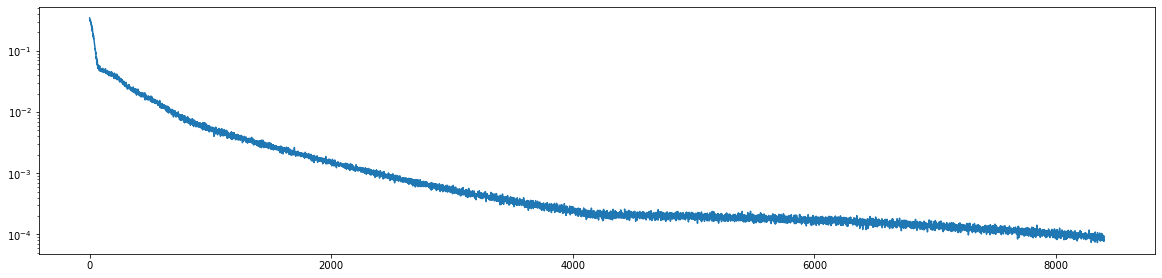

In [11]:
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.set_yscale('log')
plt.plot(loss_history)

In [12]:
# evaluate model with MAE
test_mae = calc_mae_test_fn()
print(test_mae.numpy())

27.62303017877828


In [13]:
# clone a model for every track
models = []

for i in range(50):
  print(".", end='')
  model_copy = tf.keras.models.clone_model(rnn_model)
  model_copy.set_weights(rnn_model.get_weights())
  models.append(model_copy)

..................................................

In [0]:
# use multiple models to predict different particles
tracks = []
number_tracks = 50
for i in range(number_tracks):
  tracks.append([np.array([[[random.random(), random.random()]]]*batch_size)])

# reset states
for model in models:
  model.reset_states()

for t in range(25):
  for i in range(number_tracks):
    old_pos = tracks[i][-1]
    new_pos = models[i](old_pos).numpy()
    tracks[i].append(new_pos)

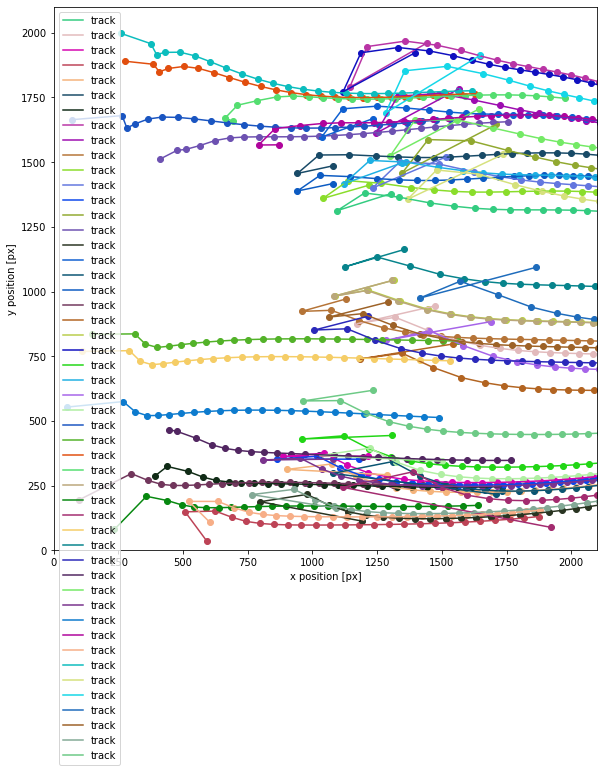

In [40]:
for i in range(number_tracks):
  track = np.array(tracks[i])[:, 0, :, :].reshape(1, 26, 2)
  normalized_track = fake_data_set.denormalize_tracks(track).reshape(26, 2)
  fake_data_set.plot_track(normalized_track, color=np.random.rand(3))